In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Data Pre-Processing**

In [ ]:
base_dir = '/content/drive/MyDrive/Colab Notebooks/plant_disease/data'

import os
print("base exists:", os.path.exists(base_dir))
print("folders:", os.listdir(base_dir))

train_dir = os.path.join(base_dir, 'Train')
val_dir   = os.path.join(base_dir, 'Validation')
test_dir  = os.path.join(base_dir, 'Test')

print("train subfolders:", os.listdir(train_dir))
print("val subfolders:", os.listdir(val_dir))
print("test subfolders:", os.listdir(test_dir))

IMG_SIZE = (128, 128)
BATCH_SIZE = 32
AUTOTUNE = None  # set later
EPOCHS = 25

base exists: True
folders: ['Test', 'Validation', 'Train']
train subfolders: ['Powdery', 'Rust', 'Healthy']
val subfolders: ['Rust', 'Healthy', 'Powdery']
test subfolders: ['Rust', 'Powdery', 'Healthy']


**Create tf datasets (train/val/test)**

In [ ]:
import tensorflow as tf
AUTOTUNE = tf.data.AUTOTUNE

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=123
)
class_names = train_ds.class_names
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("Classes (inferred):", train_ds.class_names)
NUM_CLASSES = len(train_ds.class_names)


Found 1322 files belonging to 3 classes.
Found 60 files belonging to 3 classes.
Found 150 files belonging to 3 classes.
Classes (inferred): ['Healthy', 'Powdery', 'Rust']


**Normalization**

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x,y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
val_ds   = val_ds.map(lambda x,y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)
test_ds  = test_ds.map(lambda x,y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)


**Data augmentation**

In [ ]:
'''data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.08),
    tf.keras.layers.RandomZoom(0.08),
])'''

"data_augmentation = tf.keras.Sequential([\n    tf.keras.layers.RandomFlip('horizontal'),\n    tf.keras.layers.RandomRotation(0.08),\n    tf.keras.layers.RandomZoom(0.08),\n])"

**Building CNN Model**

In [ ]:
from tensorflow.keras import layers, models

def make_model(input_shape=(128,128,3), num_classes=3, augment=True):
    inputs = layers.Input(shape=input_shape)
    '''
    x = inputs
    if augment:
        x = data_augmentation(x)'''
    x = inputs
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model

model = make_model(input_shape=IMG_SIZE+(3,), num_classes=NUM_CLASSES, augment=True)
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,288,067 (16.36 MB)

 Trainable params: 4,288,067 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

**Model Compilation**

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

checkpoint_path = '/content/drive/MyDrive/Colab Notebooks/plant_disease/models/plant_model_best.h5'
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)

callbacks = [
    ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', verbose=1),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]


**Model Training**

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/25
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.3815 - loss: 1.1208
Epoch 1: val_loss improved from inf to 0.77060, saving model to /content/drive/MyDrive/Colab Notebooks/plant_disease/models/plant_model_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 60s 231ms/step - accuracy: 0.3864 - loss: 1.1143 - val_accuracy: 0.6500 - val_loss: 0.7706 - learning_rate: 0.0010
Epoch 2/25
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6513 - loss: 0.7337
Epoch 2: val_loss improved from 0.77060 to 0.47471, saving model to /content/drive/MyDrive/Colab Notebooks/plant_disease/models/plant_model_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6523 - loss: 0.7322 - val_accuracy: 0.8500 - val_loss: 0.4747 - learning_rate: 0.0010
Epoch 3/25
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8000 - loss: 0.4924
Epoch 3: val_loss did not improve from 0.47471
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7999 - loss: 0.4923 - val_accuracy: 0.7333 - val_loss: 0.5622 - learning_rate: 0.0010
Epoch 4/25
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8933 - loss: 0.3093
Epoch 4: val_loss improved from 0.47471 to 0.38936, saving model to /content/drive/MyDrive/Colab Notebooks/plant_disease/models/plant_model_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8931 - loss: 0.3090 - val_accuracy: 0.8000 - val_loss: 0.3894 - learning_rate: 0.0010
Epoch 5/25
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9102 - loss: 0.2494
Epoch 5: val_loss improved from 0.38936 to 0.31576, saving model to /content/drive/MyDrive/Colab Notebooks/plant_disease/models/plant_model_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9107 - loss: 0.2486 - val_accuracy: 0.8833 - val_loss: 0.3158 - learning_rate: 0.0010
Epoch 6/25
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9260 - loss: 0.1933
Epoch 6: val_loss did not improve from 0.31576
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9259 - loss: 0.1942 - val_accuracy: 0.8000 - val_loss: 0.4034 - learning_rate: 0.0010
Epoch 7/25
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9366 - loss: 0.1870
Epoch 7: val_loss did not improve from 0.31576
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9370 - loss: 0.1866 - val_accuracy: 0.8000 - val_loss: 0.5924 - learning_rate: 0.0010
Epoch 8/25
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9402 - loss: 0.1707
Epoch 8: val_loss improved from 0.31576 to 0.29467, saving model to /content/drive/MyDrive/Colab Notebooks/plant_disease/models/plant_model_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9402 - loss: 0.1707 - val_accuracy: 0.8833 - val_loss: 0.2947 - learning_rate: 0.0010
Epoch 9/25
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9719 - loss: 0.0959
Epoch 9: val_loss improved from 0.29467 to 0.27324, saving model to /content/drive/MyDrive/Colab Notebooks/plant_disease/models/plant_model_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9717 - loss: 0.0957 - val_accuracy: 0.9167 - val_loss: 0.2732 - learning_rate: 0.0010
Epoch 10/25
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9862 - loss: 0.0491
Epoch 10: val_loss did not improve from 0.27324
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9861 - loss: 0.0498 - val_accuracy: 0.9000 - val_loss: 0.3652 - learning_rate: 0.0010
Epoch 11/25
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9726 - loss: 0.0717
Epoch 11: val_loss improved from 0.27324 to 0.22228, saving model to /content/drive/MyDrive/Colab Notebooks/plant_disease/models/plant_model_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9727 - loss: 0.0716 - val_accuracy: 0.9333 - val_loss: 0.2223 - learning_rate: 0.0010
Epoch 12/25
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9797 - loss: 0.0753
Epoch 12: val_loss did not improve from 0.22228
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9796 - loss: 0.0754 - val_accuracy: 0.9500 - val_loss: 0.2269 - learning_rate: 0.0010
Epoch 13/25
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9699 - loss: 0.0735
Epoch 13: val_loss improved from 0.22228 to 0.17411, saving model to /content/drive/MyDrive/Colab Notebooks/plant_disease/models/plant_model_best.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9700 - loss: 0.0736 - val_accuracy: 0.9667 - val_loss: 0.1741 - learning_rate: 0.0010
Epoch 14/25
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9909 - loss: 0.0366
Epoch 14: val_loss did not improve from 0.17411
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9908 - loss: 0.0367 - val_accuracy: 0.9333 - val_loss: 0.2732 - learning_rate: 0.0010
Epoch 15/25
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9882 - loss: 0.0348
Epoch 15: val_loss did not improve from 0.17411
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9880 - loss: 0.0353 - val_accuracy: 0.9000 - val_loss: 0.2599 - learning_rate: 0.0010
Epoch 16/25
41/42 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9891 - loss: 0.0707
Epoch 16: val_loss did not improve from 0.17411

Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9891 - loss: 0.0699 - val_accuracy: 0.9333 - v

**Plotting graphs**

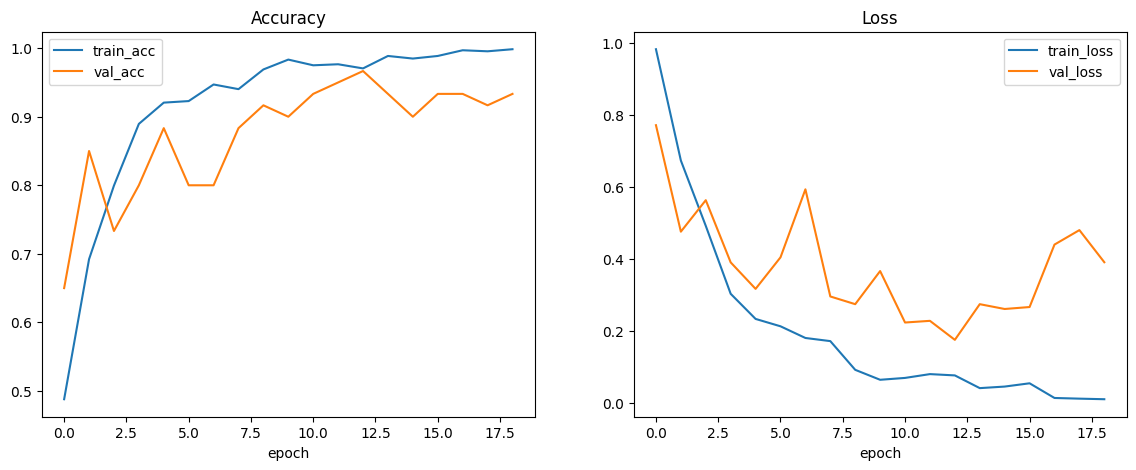

In [ ]:
import matplotlib.pyplot as plt

def plot_history(h):
    plt.figure(figsize=(14,5))
    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(h.history['accuracy'], label='train_acc')
    if 'val_accuracy' in h.history:
        plt.plot(h.history['val_accuracy'], label='val_acc')
    plt.legend(); plt.title('Accuracy'); plt.xlabel('epoch')

    # Loss
    plt.subplot(1,2,2)
    plt.plot(h.history['loss'], label='train_loss')
    if 'val_loss' in h.history:
        plt.plot(h.history['val_loss'], label='val_loss')
    plt.legend(); plt.title('Loss'); plt.xlabel('epoch')
    plt.show()

plot_history(history)


**Evaluating on test set**

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.9374 - loss: 0.2362
Test loss: 0.2654, Test accuracy: 0.9333


**Confusion Matrix and Classification Report**

Using class names (sorted): ['Healthy', 'Powdery', 'Rust']
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 626ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
Total test samples: 150
Unique true classes found: [0 1 2]
Unique pred classes found: [0 1 2]
Confusion matrix:
 [[49  1  0]
 [ 6 44  0]
 [ 3  0 47]]

Classification report:

              precision    recall  f1-score   support

     Healthy       0.84      0.98      0.91        50
     Powdery       0.98      0.88      0.93        50
        Rust       1.00      0.94      0.97        50

    accuracy                           0.93       150
   macro avg       0.94      0.93      0.93       150
weighted avg       0.94      0.93      0.93       150



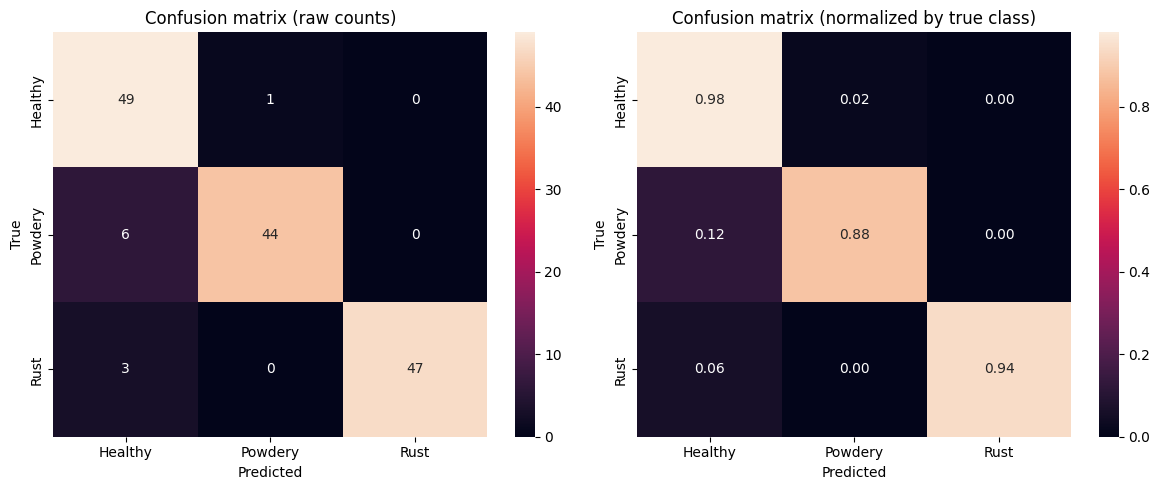

In [ ]:

import os
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

train_subs = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
class_names = sorted(train_subs)
print("Using class names (sorted):", class_names)

# 2) Collect true labels and predictions from test_ds
y_true = []
y_pred = []

# Make sure model is available and test_ds yields batches of (images, labels)
for images, labels in test_ds:
    preds = model.predict(images)            # (batch, num_classes)
    y_pred.extend(np.argmax(preds, axis=1))  # integer class indices
    # labels may be one-hot or ints
    if labels.ndim == 2:                     # one-hot
        y_true.extend(np.argmax(labels.numpy(), axis=1))
    else:                                    # already ints
        y_true.extend(labels.numpy().astype(int))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("Total test samples:", len(y_true))
print("Unique true classes found:", np.unique(y_true))
print("Unique pred classes found:", np.unique(y_pred))

# 3) Confusion matrix and classification report
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)


if cm.shape[0] != len(class_names):
    print("WARNING: confusion matrix shape", cm.shape, "does not match number of class names", len(class_names))

    max_idx = max(y_true.max(), y_pred.max())
    if max_idx + 1 == cm.shape[0]:

        class_names = class_names + [f"class_{i}" for i in range(len(class_names), cm.shape[0])]
        print("Adjusted class_names ->", class_names)

print("\nClassification report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion matrix (raw counts)')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.subplot(1,2,2)
cm_norm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-12)  # normalize by true counts
sns.heatmap(cm_norm, annot=True, fmt='.2f', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion matrix (normalized by true class)')
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()


**Saving the model as h5**

In [ ]:
final_path = '/content/drive/MyDrive/Colab Notebooks/models/plant_model_final.h5'
model.save(final_path)
print("Saved final model to:", final_path)


Saved final model to: /content/drive/MyDrive/Colab Notebooks/models/plant_model_final.h5


In [ ]:
model.fit(train_ds, validation_data=val_ds, epochs=1)


**Saving the model as keras**

In [ ]:
from tensorflow.keras.models import load_model
model_h5 = load_model('/content/drive/MyDrive/Colab Notebooks/models/plant_model_final.h5')
model_h5.summary()

model_h5.save('/content/drive/MyDrive/Colab Notebooks/models/plant_model_final.keras')


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,288,069 (16.36 MB)

 Trainable params: 4,288,067 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

**To check if weights are loaded or not**

In [ ]:
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/Colab Notebooks/models/plant_model_final.keras')

# check that weights really loaded
print("Weights loaded? Layers:", len(model.layers))
model.summary()  # should match before-saving summary

# check first prediction
for images, labels in test_ds.take(1):
    preds = model.predict(images)
    print("Prediction shape:", preds.shape)
    break


Weights loaded? Layers: 11


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,864,203 (49.07 MB)

 Trainable params: 4,288,067 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,576,136 (32.72 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
Prediction shape: (32, 3)


In [ ]:
import os, json

train_dir = '/content/drive/MyDrive/Colab Notebooks/plant_disease/data/Train'
class_names = sorted([d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))])
print("class_names:", class_names)

out_path = '/content/drive/MyDrive/Colab Notebooks/models/class_names.json'
os.makedirs(os.path.dirname(out_path), exist_ok=True)
with open(out_path, 'w') as f:
    json.dump(class_names, f)

print("Saved class_names.json to:", out_path)


class_names: ['Healthy', 'Powdery', 'Rust']
Saved class_names.json to: /content/drive/MyDrive/Colab Notebooks/models/class_names.json


Loaded model from: /content/drive/MyDrive/Colab Notebooks/models/plant_model_final.keras
Loaded class names: ['Healthy', 'Powdery', 'Rust']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
Top predictions:
  Powdery (index 1) — 98.65%
  Rust (index 2) — 1.31%
  Healthy (index 0) — 0.04%


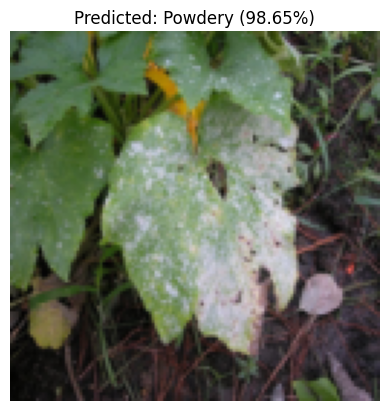

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from PIL import Image
import matplotlib.pyplot as plt
import json, os

MODEL_PATH = '/content/drive/MyDrive/Colab Notebooks/models/plant_model_final.keras'
CLASS_JSON = '/content/drive/MyDrive/Colab Notebooks/models/class_names.json'
IMG_SIZE = (128, 128)
SCALE = True

# 1) Load model & class names
model = load_model(MODEL_PATH)
print("Loaded model from:", MODEL_PATH)
with open(CLASS_JSON, 'r') as f:
    class_names = json.load(f)
print("Loaded class names:", class_names)

# 2) Preprocess helper
def preprocess_image_path(image_path, img_size=IMG_SIZE, scale=SCALE):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(img_size, Image.BILINEAR)
    arr = np.array(img).astype('float32')
    if scale:
        arr = arr / 255.0
    arr = np.expand_dims(arr, axis=0)   # batch dim
    return arr, img

# 3) Predict helper
def predict_image_path(image_path, top_k=3):
    x, pil_img = preprocess_image_path(image_path)
    preds = model.predict(x)  # shape (1, num_classes)
    probs = preds[0]
    idxs = probs.argsort()[::-1][:top_k]
    results = [(class_names[i], float(probs[i]), int(i)) for i in idxs]
    return results, pil_img

image_path = '/content/drive/MyDrive/Colab Notebooks/plant_disease/powdery_mildew.jpg'

results, pil_img = predict_image_path(image_path, top_k=3)
print("Top predictions:")
for name, prob, idx in results:
    print(f"  {name} (index {idx}) — {prob*100:.2f}%")

top_name, top_prob, _ = results[0]
plt.imshow(pil_img)
plt.axis('off')
plt.title(f"Predicted: {top_name} ({top_prob*100:.2f}%)")
plt.show()


In [ ]:
from tensorflow.keras.models import load_model

# Load best checkpoint
model_best = load_model('/content/drive/MyDrive/Colab Notebooks/plant_disease/models/plant_model_best.h5')

# Load final model
model_final = load_model('/content/drive/MyDrive/Colab Notebooks/models/plant_model_final.keras')

# Evaluate both on the same test set
print("Best checkpoint:")
model_best.evaluate(test_ds)

print("Final model:")
model_final.evaluate(test_ds)


Best checkpoint:
5/5 ━━━━━━━━━━━━━━━━━━━━ 47s 9s/step - accuracy: 0.8837 - loss: 53.3338
Final model:
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 924ms/step - accuracy: 0.8837 - loss: 53.3338


[50.54054260253906, 0.8933333158493042]